<font size="24">FUTURE SALES FORECASTING </font>

**File description**:

<font size="5">

- **sales_train.csv** : The training set. Daily historical data from January 2013 to October 2015.
- **test.csv**: The test set. You need to forecast the sales for these shops and products for November 2015.
- **sample_submission**: A sample submission file in the correct format.
- **items.csv**: Supplemental information about the items/products.
- **item_categories**: Supplemental information about the items categories.
- **shops.csv**: Supplemental information about the shops.

</font>

**Data fields**:

<font size="5">

- **ID**:  An Id that represents a (Shop, Item) tuple within the test set
- **shop_id**:  Unique identifier of a shop
- **item_id**: Unique identifier of a product
- **item_category_id**: Unique identifier of item category
- **item_cnt_day**: Number of products sold. You are predicting a monthly amount of this measure
- **item_price**: Current price of an item
- **date**: Date in format dd/mm/yyyy
- **date_block_num**: A consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **item_name**: Name of item
- **shop_name**: Name of shop
- **item_category_name**: Name of item category

</font>

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import re
import copy

import os
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings("ignore")

In [225]:
class ETL:
    def __init__(self, data_path):
        self.option = ['shop', 'train', 'item', 'test', 'category']
        self.file_name = os.path.basename(data_path)

        self.df = pd.read_csv(data_path)
        print("{} rows and {} columns has been read from {}".format(self.df.shape[0], self.df.shape[1], self.file_name))

        self.dqc = DQC(self.df)

    def transform_data(self, option):
        if option.lower() == 'train' and option.lower() in self.option:
            self.df = self.dqc.train_fix()
            self.df = self.dqc.isolation_forest(['item_price', 'item_cnt_day'], change=True)

        if option.lower() == 'test' and option.lower() in self.option:
            self.dqc.test_fix()

        if option.lower() == 'item' and option.lower() in self.option:
            self.dqc.item_fix()

        if option.lower() == 'shop' and option.lower() in self.option:
            self.dqc.shop_fix()

        if option.lower() == 'category' and option.lower() in self.option:
            self.dqc.item_category_fix()

    def get_data(self):
        self.df = self.dqc.get_data()
        return self.df

    def load_data(self, file_name):
        self.df.to_csv(file_name + '.csv')
        print("File {} was successfully saved".format(file_name))


In [226]:
class DQC:
    def __init__(self, df=None):
        self.df = df

    # Basic functions
    def get_data(self, option=False):
        if option:
            return self.df[option]
        return self.df

    # Statistic
    def statistic(self):
        print("Information about data:\n")
        print(f"{self.df.info()}\n\n{'=' * 50}\n")
        print("Some examples of data:\n")
        print(f"{self.df.head(10)}\n\n{'=' * 50}\n")
        print("Number of unique data:\n")
        print(f"{self.df.nunique()}\n\n{'=' * 50}\n")
        print(f"Number of dublicated data: {self.df.duplicated().sum()}")

    def describe_matrix(self, column_list):
        print(self.df[column_list].describe().T)

    # Items fix
    def item_fix(self):
        # fix item name
        def clean_name(string):
            string = re.sub(r"\[.*?\]", "", string)
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
            string = re.sub(r"\s{2,}", " ", string)
            string = string.lower()
            return string

        self.df["cleaned_name"] = self.df["item_name"].apply(clean_name)

    # Shops fix
    def shop_fix(self):
        # shop id fix
        shops_id_fix = {0: 57, 1: 58, 10: 11, 40: 39}
        self.df.drop(index=shops_id_fix.keys(), inplace=True)

        # add new column city
        self.df.loc[self.df.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"] = 'СергиевПосад ТЦ "7Я"'
        self.df['city'] = self.df['shop_name'].str.split(' ').map(lambda x: x[0])

    # train fix
    def train_fix(self):
        #drop duplicates
        self.df.drop_duplicates(inplace=True)

        # datetime fix
        self.df['date'] = pd.to_datetime(self.df['date'], format='%d.%m.%Y')

        # shop id fix
        shops_id_fix = {0: 57, 1: 58, 10: 11, 40: 39}
        self.df = self.df.replace({'shop_id': shops_id_fix})

        # drop extreme or negative values 
        self.df = self.df.loc[(self.df['item_price'] < 50000) & (self.df['item_price'] > 0)]
        self.df = self.df.loc[(self.df['item_cnt_day'] < 700) & (self.df['item_cnt_day'] > 0)]

        # test fix
    def test_fix(self):
        # shop id fix
        shops_id_fix = {0: 57, 1: 58, 10: 11, 40: 39}
        self.df = self.df.replace({'shop_id': shops_id_fix})

    # item category fix
    def item_category_fix(self):
        # add new column global category 
        self.df['category'] = self.df['item_category_name'].apply(lambda x: x.split()[0])

    # Graphics
    def boxplots(self, columns):
        fig = plt.figure(figsize=(10, 5))
        for n, i in enumerate(columns):
            plt.subplot(1, len(columns), n + 1)
            plt.xlabel(i)
            sns.boxplot(data=self.df, x=i)
        plt.tight_layout()
        plt.show()

    def histplots(self, columns):
        fig = plt.figure(figsize=(10, 5))
        for n, i in enumerate(columns):
            plt.subplot(1, len(columns), n + 1)
            plt.xlabel(i)
            sns.histplot(data=self.df, x=i)
        plt.tight_layout()
        plt.show()

    # Outliers
    def z_score(self, column, info=False, change=False):
        self.df['z_score'] = (self.df[column] - self.df[column].mean()) / self.df[column].std()
        outliers = self.df[(self.df['z_score'] < -3) | (self.df['z_score'] > 3)]

        if info:
            print(f"{'=' * 50}\n\nZ_score outliers detection:\n")
            print("Number of outliers: {}".format(outliers.shape[0]))
            print("Outlier share in {0}: {1}%".format(column, round((outliers.shape[0] / self.df.shape[0] * 100), 3)))
            print(f"\n{'=' * 50}")

        if change:
            self.df = self.df[(self.df['z_score'] > -3) & (self.df['z_score'] < 3)]
            # self.df.drop('z_score', axis=1, inplace=True)

    def outlier_detect_IQR(self, columns, threshold=3, info=False, change=False):
        outlier_indices = []
        outliers = []
        for col in columns:
            IQR = self.df[col].quantile(0.75) - self.df[col].quantile(0.25)
            lower_fence = self.df[col].quantile(0.25) - (IQR * threshold)
            upper_fence = self.df[col].quantile(0.75) + (IQR * threshold)
            tmp = pd.concat([self.df[col] > upper_fence, self.df[col] < lower_fence], axis=1)
            outlier_index = tmp.any(axis=1)
            outlier_indices.extend(outlier_index[outlier_index].index)
            outliers.extend(self.df.loc[outlier_index, col])

            if info:
                print(f"{'=' * 50}\n\nIQR outliers detection:\n")
                print("Number of outliers in {0}: {1}".format(col, outlier_index.sum()))
                print("Outlier share in {0}: {1}%".format(col,
                                                          round((outlier_index.sum() / len(outlier_index) * 100), 3)))
                print(f"\n{'=' * 50}\n")

        if change:
            self.df = self.df[~self.df.index.isin(outlier_indices)]

    def isolation_forest(self, columns, info=False, change=False):
        clf = IsolationForest(n_jobs=-1)
        labels = clf.fit_predict(self.df[columns].to_numpy())

        if info:
            print(f"{'=' * 50}\n\nIsolation forest outliers detection:\n")
            print("Number of outliers: {}".format(np.count_nonzero(labels == -1)))
            print("Outlier share: {0}%".format(round((np.count_nonzero(labels == -1) / len(labels) * 100), 3)))
            print(f"\n{'=' * 50}")

        if change:
            outliers = [i for i in range(0, len(labels)) if labels[i] == -1]
            self.df = self.df.drop(self.df.iloc[outliers].index, axis=0).copy(deep=True)


In [229]:
item_categories = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/item_categories.csv')
items = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/items.csv')
sales = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/sales_train.csv')
shops = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/shops.csv')
test = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/test.csv')

84 rows and 2 columns has been read from item_categories.csv
22170 rows and 3 columns has been read from items.csv
2935849 rows and 6 columns has been read from sales_train.csv
60 rows and 2 columns has been read from shops.csv
214200 rows and 3 columns has been read from test.csv


<font size = 8>

**item categories**:

</font>

In [230]:
item_categories.dqc.statistic()

Information about data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None


Some examples of data:

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
7    Аксессуары - XBOX ONE                 7
8           Билеты (Цифра)                 8
9          Доставка товара                 9


Number of unique data:

item_category_name    84
item_category_id      84
dtype: int64


Number of dubl

In [231]:
item_categories_df = item_categories.dqc.get_data()

In [232]:
item_categories_df.loc[item_categories_df['item_category_id'].isin([33, 34, 43, 44, 69, 70, 75, 76, 77, 78])]

,item_category_name,item_category_id
33,Карты оплаты - Live!,33
34,Карты оплаты - Live! (Цифра),34
43,Книги - Аудиокниги,43
44,Книги - Аудиокниги (Цифра),44
69,Подарки - Сувениры,69
70,Подарки - Сувениры (в навеску),70
75,Программы - Для дома и офиса,75
76,Программы - Для дома и офиса (Цифра),76
77,Программы - Обучающие,77
78,Программы - Обучающие (Цифра),78


<font size = 5>

<b>'Цифра' means that this item sold in digital format
'В навестку' means that this item goes as a gift or at a discount to the main product</b>


</font>

<font size = 8>

**Items**:

</font>

In [233]:
items.dqc.statistic()

Information about data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None


Some examples of data:

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   
5  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   
6           ***УДАР ПО ВОРОТАМ (UNI)               D        6   
7         ***УДАР ПО ВОРОТАМ-2 (UN

<font size = 8>

**Sales_train**:

</font>

In [234]:
sales.dqc.statistic()

Information about data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


Some examples of data:

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013     

In [235]:
sales.dqc.describe_matrix(column_list=['date', 'item_price', 'item_cnt_day'])

                  count        mean          std   min    25%    50%    75%  \
item_price    2935849.0  890.853233  1729.799631  -1.0  249.0  399.0  999.0   
item_cnt_day  2935849.0    1.242641     2.618834 -22.0    1.0    1.0    1.0   

                   max  
item_price    307980.0  
item_cnt_day    2169.0  


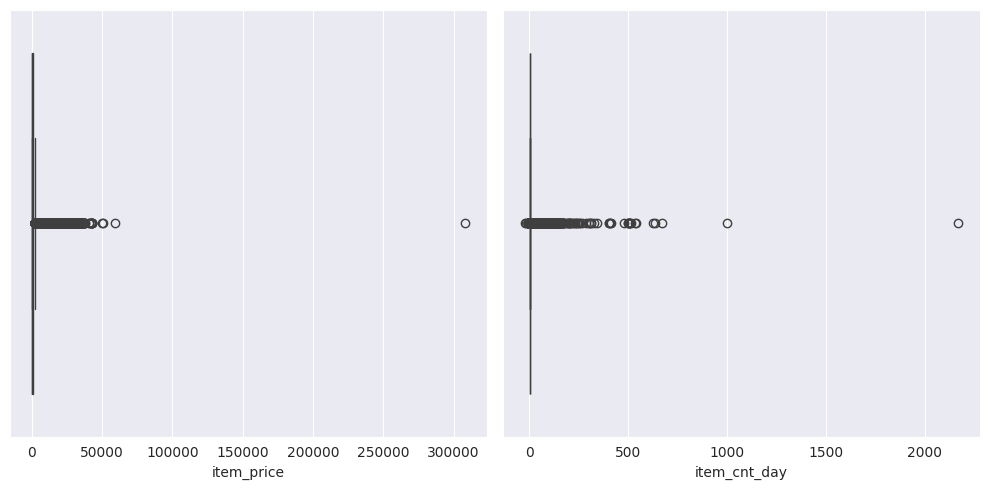

In [236]:
sales.dqc.boxplots(columns=['item_price', 'item_cnt_day'])

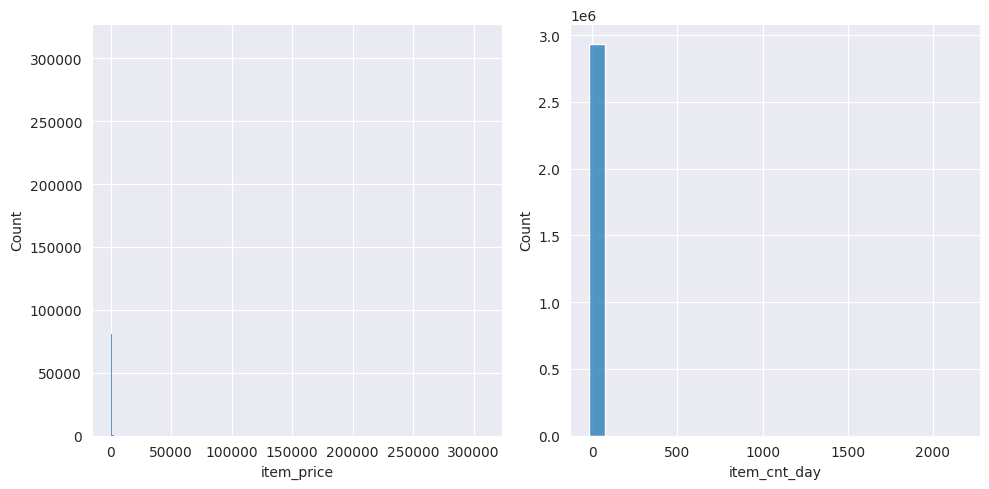

In [237]:
sales.dqc.histplots(columns=['item_price', 'item_cnt_day'])

In [238]:
sales_df = sales.dqc.get_data()

In [239]:
sales_df[sales_df['item_price'] < 1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.000000,1.0
531561,16.06.2013,5,30,11859,0.100000,1.0
531564,13.06.2013,5,30,11855,0.100000,1.0
531566,06.06.2013,5,30,11858,0.100000,1.0
531567,09.06.2013,5,30,11858,0.100000,1.0
...,...,...,...,...,...,...
2898267,02.10.2015,33,58,15334,0.990000,1.0
2898268,11.10.2015,33,58,15334,0.990000,1.0
2898269,01.10.2015,33,58,15344,0.990000,2.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


<font size = 5>

<b> One negative value, and a lot of not realistic price as 0.1</b>

</font>

In [240]:
sales_df[sales_df['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


<font size = 5>

<b> A log of negative values in the item_cnt_day column</b>

</font>

<font size = 8>

**Shops**:

</font>

In [241]:
shops.dqc.statistic()

Information about data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


Some examples of data:

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
7          Воронеж ТРЦ "Максимир"        7
8    Воронеж ТРЦ Сити-Парк "Град"        8
9               Выездная Торговля        9


Number of unique data:

shop_name    60
shop_id      60
dtype: int64


Number of dublicated data: 0


In [242]:
shops_df = shops.dqc.get_data()

In [243]:
shops_df[shops_df['shop_id'].isin([0, 1, 10, 11, 39, 40, 57, 58])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
39,"РостовНаДону ТРК ""Мегацентр Горизонт""",39
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


<font size = 5>

<b> Duplicates in store names , need to change and delete these duplicates</b>

</font>

<font size = 8>

**Test**:

</font>

In [244]:
test.dqc.statistic()

Information about data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


Some examples of data:

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5     5041
7   7        5     5046
8   8        5     5319
9   9        5     5003


Number of unique data:

ID         214200
shop_id        42
item_id      5100
dtype: int64


Number of dublicated data: 0


In [245]:
test_df = test.dqc.get_data()
sales_df = sales.dqc.get_data()

In [246]:
unique_test_items = test_df['item_id'][~test_df['item_id'].isin(sales_df['item_id'].unique())].unique()
unique_test_shops = test_df['shop_id'][~test_df['shop_id'].isin(sales_df['shop_id'].unique())].unique()

In [247]:
print('Unique items in test: {}\nUnique shops in test: {}'.format(len(unique_test_items), len(unique_test_shops)))

Unique items in test: 363
Unique shops in test: 0


In [248]:
unique_train_items = sales_df['item_id'][~sales_df['item_id'].isin(test_df['item_id'].unique())].unique()
unique_train_shops = sales_df['shop_id'][~sales_df['shop_id'].isin(test_df['shop_id'].unique())].unique()

In [249]:
print('Unique items in train: {}\nUnique shops in train: {}'.format(len(unique_train_items), len(unique_train_shops)))

Unique items in train: 17070
Unique shops in train: 18


In [250]:
del item_categories, items, sales, shops, test

<font size = 6>

**Outliers with extreme values fix**:


</font>

In [252]:
sales = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/sales_train.csv')

2935849 rows and 6 columns has been read from sales_train.csv


In [253]:
sales.dqc.train_fix()

In [254]:
sales_z = copy.deepcopy(sales)
sales_forest = copy.deepcopy(sales)
sales_IQR = copy.deepcopy(sales)

In [255]:
sales_z.dqc.z_score(column='item_price', info=True)
sales_z.dqc.z_score(column='item_cnt_day', info=True)
sales_IQR.dqc.outlier_detect_IQR(columns=['item_price', 'item_cnt_day'], threshold=3, info=True)
sales_forest.dqc.isolation_forest(columns=['item_price', 'item_cnt_day'], info=True)


Z_score outliers detection:

Number of outliers: 28512
Outlier share in item_price: 0.974%


Z_score outliers detection:

Number of outliers: 17014
Outlier share in item_cnt_day: 0.581%


IQR outliers detection:

Number of outliers in item_price: 78356
Outlier share in item_price: 2.676%



IQR outliers detection:

Number of outliers in item_cnt_day: 299119
Outlier share in item_cnt_day: 10.214%


Isolation forest outliers detection:

Number of outliers: 336468
Outlier share: 11.49%



In [256]:
sales_z.dqc.z_score(column='item_price', info=True, change=True)
sales_z.dqc.z_score(column='item_cnt_day', info=True, change=True)
sales_IQR.dqc.outlier_detect_IQR(columns=['item_price', 'item_cnt_day'], info=True, change=True)
sales_forest.dqc.isolation_forest(columns=['item_price', 'item_cnt_day'], info=True, change=True)


Z_score outliers detection:

Number of outliers: 28512
Outlier share in item_price: 0.974%


Z_score outliers detection:

Number of outliers: 16774
Outlier share in item_cnt_day: 0.578%


IQR outliers detection:

Number of outliers in item_price: 78356
Outlier share in item_price: 2.676%



IQR outliers detection:

Number of outliers in item_cnt_day: 299119
Outlier share in item_cnt_day: 10.214%


Isolation forest outliers detection:

Number of outliers: 365309
Outlier share: 12.474%



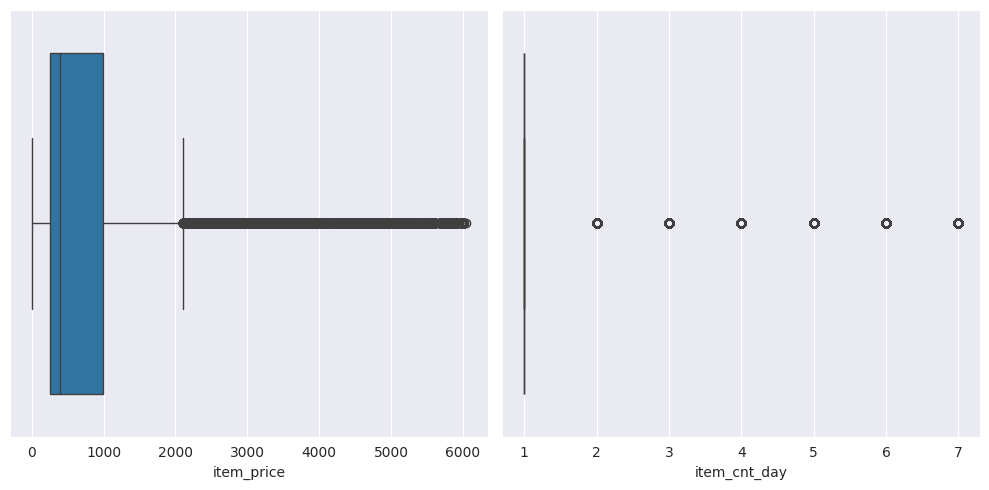

In [257]:
sales_z.dqc.boxplots(columns=['item_price', 'item_cnt_day'])

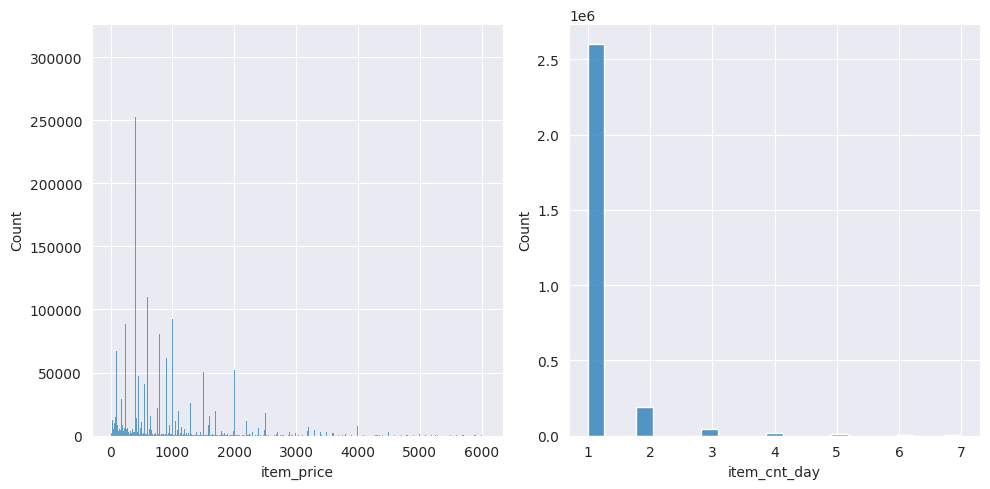

In [258]:
sales_z.dqc.histplots(columns=['item_price', 'item_cnt_day'])

In [259]:
sales_df = sales_z.dqc.get_data()
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,z_score
0,2013-01-02,0,59,22154,999.00,1.0,-0.111181
1,2013-01-03,0,25,2552,899.00,1.0,-0.111181
3,2013-01-06,0,25,2554,1709.05,1.0,-0.111181
4,2013-01-15,0,25,2555,1099.00,1.0,-0.111181
5,2013-01-10,0,25,2564,349.00,1.0,-0.111181
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,-0.111181
2935845,2015-10-09,33,25,7460,299.00,1.0,-0.111181
2935846,2015-10-14,33,25,7459,349.00,1.0,-0.111181
2935847,2015-10-22,33,25,7440,299.00,1.0,-0.111181


In [260]:
sales_df[(sales_df['item_cnt_day'] < 0) | (sales_df['item_price'] < 1)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,z_score
531561,2013-06-16,5,30,11859,0.10,1.0,-0.111181
531564,2013-06-13,5,30,11855,0.10,1.0,-0.111181
531566,2013-06-06,5,30,11858,0.10,1.0,-0.111181
531567,2013-06-09,5,30,11858,0.10,1.0,-0.111181
531568,2013-06-14,5,30,11858,0.10,1.0,-0.111181
...,...,...,...,...,...,...,...
2898266,2015-10-01,33,58,15334,0.99,1.0,-0.111181
2898267,2015-10-02,33,58,15334,0.99,1.0,-0.111181
2898268,2015-10-11,33,58,15334,0.99,1.0,-0.111181
2898269,2015-10-01,33,58,15344,0.99,2.0,0.340218


In [261]:
del sales_df

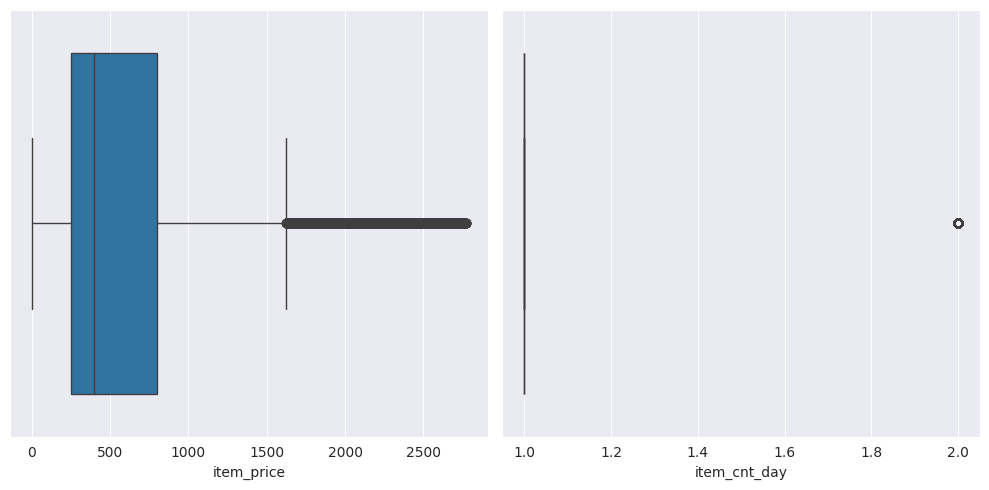

In [262]:
sales_forest.dqc.boxplots(columns=['item_price', 'item_cnt_day'])

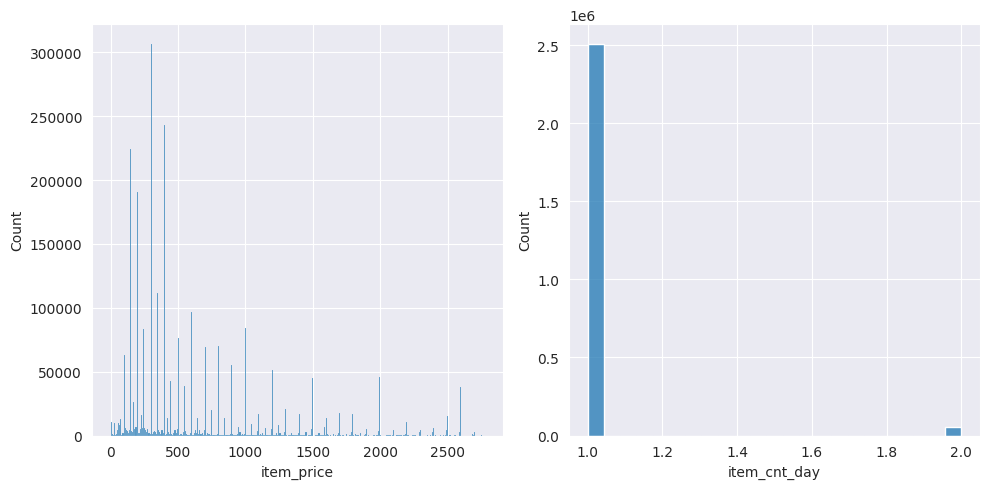

In [263]:
sales_forest.dqc.histplots(columns=['item_price', 'item_cnt_day'])

In [264]:
sales_df = sales_forest.dqc.get_data()
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [265]:
sales_df[(sales_df['item_cnt_day'] < 0) | (sales_df['item_price'] < 1)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
531561,2013-06-16,5,30,11859,0.10,1.0
531564,2013-06-13,5,30,11855,0.10,1.0
531566,2013-06-06,5,30,11858,0.10,1.0
531567,2013-06-09,5,30,11858,0.10,1.0
531568,2013-06-14,5,30,11858,0.10,1.0
...,...,...,...,...,...,...
2885073,2015-10-01,33,44,15345,0.99,1.0
2898266,2015-10-01,33,58,15334,0.99,1.0
2898267,2015-10-02,33,58,15334,0.99,1.0
2898268,2015-10-11,33,58,15334,0.99,1.0


In [266]:
del sales_df

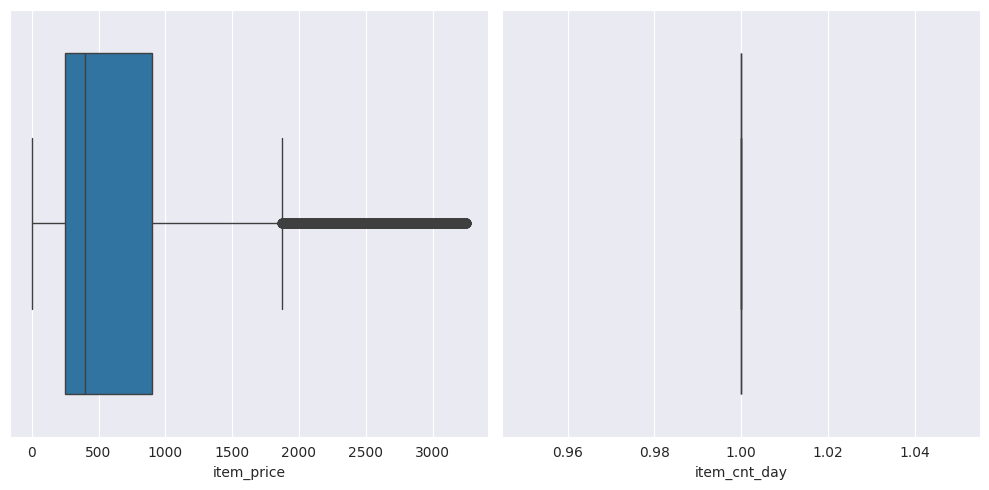

In [267]:
sales_IQR.dqc.boxplots(columns=['item_price', 'item_cnt_day'])

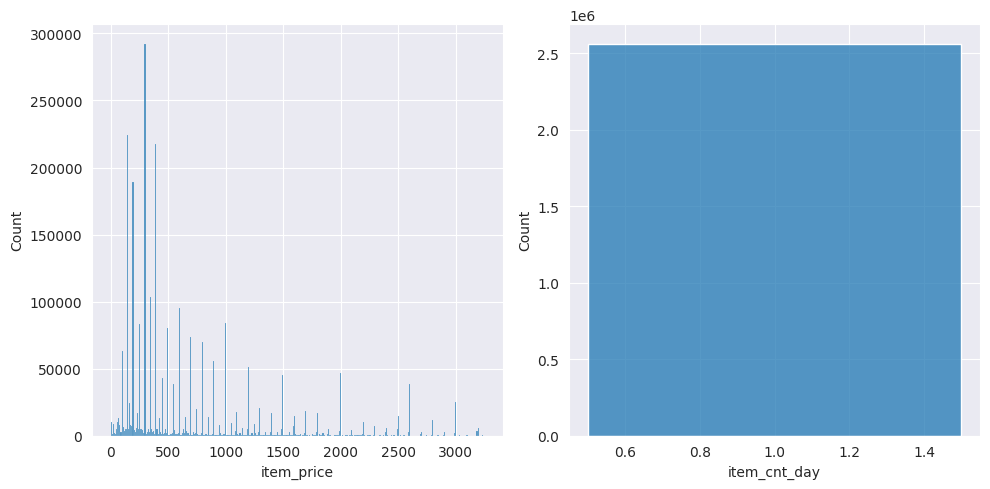

In [268]:
sales_IQR.dqc.histplots(columns=['item_price', 'item_cnt_day'])

In [269]:
sales_df = sales_IQR.dqc.get_data()
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [270]:
sales_df[(sales_df['item_cnt_day'] < 0) | (sales_df['item_price'] < 1)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
531561,2013-06-16,5,30,11859,0.10,1.0
531564,2013-06-13,5,30,11855,0.10,1.0
531566,2013-06-06,5,30,11858,0.10,1.0
531567,2013-06-09,5,30,11858,0.10,1.0
531568,2013-06-14,5,30,11858,0.10,1.0
...,...,...,...,...,...,...
2885073,2015-10-01,33,44,15345,0.99,1.0
2898266,2015-10-01,33,58,15334,0.99,1.0
2898267,2015-10-02,33,58,15334,0.99,1.0
2898268,2015-10-11,33,58,15334,0.99,1.0


In [271]:
del sales_df, sales_IQR, sales_forest, sales_z, sales

In [272]:
shops_1 = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/shops.csv')

60 rows and 2 columns has been read from shops.csv


In [362]:
shops_1.dqc.shop_fix()

,shop_name,shop_id,city
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная
11,Жуковский ул. Чкалова 39м²,11,Жуковский
12,Интернет-магазин ЧС,12,Интернет-магазин


In [363]:
shops_1.dqc.get_data()

,shop_name,shop_id,city
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная
11,Жуковский ул. Чкалова 39м²,11,Жуковский
12,Интернет-магазин ЧС,12,Интернет-магазин


In [364]:
items_1 = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/items.csv')

22170 rows and 3 columns has been read from items.csv


In [365]:
items_1.dqc.item_fix()

,item_name,item_id,item_category_id,cleaned_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна d
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка d
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,ядерный титбит 2
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,язык запросов 1спредприятия
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,язык запросов 1спредприятия 8 хрусталева ею
22168,Яйцо для Little Inu,22168,62,яйцо для little inu


In [366]:
items_df = items_1.dqc.get_data()

In [367]:
items_df['cleaned_name'].duplicated().sum()

2690

In [368]:
item_categories_1 = ETL('/home/avocad00/InnowiseTrainee/FutureSales/data/item_categories.csv')

84 rows and 2 columns has been read from item_categories.csv


In [369]:
item_categories_1.dqc.item_category_fix()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [370]:
item_categories_1.dqc.get_data()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [371]:
categories_df = item_categories.transform_data('category')
item_df = items.transform_data('item')
sales_df = sales.transform_data('train')
shops_df = shops.transform_data('shop')
test_df = test.transform_data('test')

In [372]:
categories_df

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [373]:
item_df

,item_name,item_id,item_category_id,cleaned_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна d
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка d
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,ядерный титбит 2
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,язык запросов 1спредприятия
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,язык запросов 1спредприятия 8 хрусталева ею
22168,Яйцо для Little Inu,22168,62,яйцо для little inu


In [374]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [375]:
shops_df

,shop_name,shop_id,city
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная
11,Жуковский ул. Чкалова 39м²,11,Жуковский
12,Интернет-магазин ЧС,12,Интернет-магазин


In [376]:
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


<font size = 5>

TODO:
1) Придумать, что сделать со значениями цены, которая ниже 0.1, какойто месяц акции по ощущению произошёл в 2013.06. Сначала лучше всего оставить, посмотреть что по итогу будет на графике.
Как идея взять среднюю цену по этому продукту в другие месяца и заменить. ALERT!!! Ни в коем случае не удалять, пропадёт 1-2 месяца из данных.

2) Не все шопы , что есть в трейне - есть в тесте, не все товары, что есть в тесте - есть в трейне. Как идея можно просто выбросить эти 363 товара из теста. Трейн с уникальными товарами и шопами можно по идее не трогать, их не так много, обучение не ускорит

3) ALERT!!! не забыть после того как сделаю EDA, при соединении таблиц в одну дропнуть дубликаты. 2700 товаров повторяется, пока что не дропал, ведь там уникальные айдишники, пришлось бы менять всё в ручную. 

4) не забыть создать новых фич цены после EDA для обучения. Может точность модели возрастёт
</font>